# Background

Twitter is a micro-blogging social media platform with 217.5 million daily active users globally. With 500 million new tweets (posts) daily, the topics of these tweets varies widely – k-pop, politics, financial news… you name it! Individuals use it for news, entertainment, and discussions, while corporations use them to as a marketing tool to reach out to a wide audience. Given the freedom Twitter accords to its user, Twitter can provide a conducive environment for productive discourse, but this freedom can also be abused, manifesting in the forms of racism and sexism.

# Problem Statement

With Twitter’s significant income stream coming from advertisers, it is imperative that Twitter keeps a substantial user base. On the other hand, Twitter should maintain a safe space for users and provide some level of checks for the tweets the users put out into the public space, and the first step would be to identify tweets that espouse racist or sexist ideologies, and then Twitter can direct the users to appropriate sources of information where users can learn more about the community that they offend or their subconscious biases so they will be more aware of their racist/sexist tendencies. Thus, to balance, Twitter has to be accurate in filtering inappropriate tweets from innocuous ones, and the kind of inappropriateness of flagged tweets (tag - racist or sexist).

F1-scores will be the primary metric as it looks at both precision and recall, each looking at false positives (FPs) and false negatives (FNs) respectively, and is a popular metric for imbalanced data as is the case with the dataset used.

For the purpose of explanation, racist tweets are used as the ‘positive’ case.

In this context, FPs are the cases where the model erroneously flags out tweets as racist when the tweet is actually innocuous/sexist. FNs are cases where the model erroneously flags out tweets as innocuous/sexist but the tweets are actually racist.

Thus, higher F1-scores are preferred.

# Importing Libraries

In [1]:
# Standard libraries
import numpy as np
import pandas as pd

# For visualization
import matplotlib.pyplot as plt
import seaborn as sns

# For NLP data cleaning and preprocessing
import re, string, nltk, itertools
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer, PorterStemmer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

# Pickle to save model
import pickle

# For NLP Machine Learning processes
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from imblearn.over_sampling import RandomOverSampler, SMOTE

# Pipeline
from imblearn.pipeline import Pipeline

# Naive Bayes
from sklearn.naive_bayes import MultinomialNB

# Random Forest
from sklearn.ensemble import RandomForestClassifier

# XGBoost
import xgboost as xgb
from xgboost import XGBClassifier, plot_importance

# Support Vector Machine
from sklearn.svm import SVC

# PyTorch LSTM
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

# Tokenization for LSTM
from collections import Counter
from gensim.models import Word2Vec

# Transformers library for BERT
import transformers
from transformers import BertModel
from transformers import BertTokenizer
from transformers import AdamW, get_linear_schedule_with_warmup

# Evaluation Metrics
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import roc_auc_score, roc_curve, plot_roc_curve, RocCurveDisplay
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, plot_confusion_matrix

In [2]:
# Setting seed for reproducibility
import random

seed_value=42
random.seed(seed_value)
np.random.seed(seed_value)
torch.manual_seed(seed_value)
torch.cuda.manual_seed_all(seed_value)

In [3]:
# Changing display settings
pd.set_option('display.max_row', 100)
pd.set_option('display.max_colwidth', None)

# Importing Dataset

In [4]:
twitter_final3 = pd.read_csv('../Capstone/data/twitter_final3.csv')

In [5]:
twitter_final3.columns

Index(['Text', 'Annotation', 'oh_label', 'Text_stem', 'Text_lemm',
       'Text_stem_char_2_gram', 'Text_stem_char_3_gram',
       'Text_stem_char_4_gram', 'Text_lemm_char_2_gram',
       'Text_lemm_char_3_gram', 'Text_lemm_char_4_gram'],
      dtype='object')

In [6]:
twitter_final3.head()

,Text,Annotation,oh_label,Text_stem,Text_lemm,Text_stem_char_2_gram,Text_stem_char_3_gram,Text_stem_char_4_gram,Text_lemm_char_2_gram,Text_lemm_char_3_gram,Text_lemm_char_4_gram
0,@halalflaws @biebervalue @greenlinerzjm I read them in context.No change in meaning. The history of Islamic slavery. https://t.co/xWJzpSodGj,none,0,read contextno chang mean histori islam slaveri,read contextno change meaning history islamic slavery,re ea ad co on nt te ex xt tn no ch ha an ng me ea an hi is st to or ri is sl la am sl la av ve er ri,rea ead con ont nte tex ext xtn tno cha han ang mea ean his ist sto tor ori isl sla lam sla lav ave ver eri,read cont onte ntex text extn xtno chan hang mean hist isto stor tori isla slam slav lave aver veri,re ea ad co on nt te ex xt tn no ch ha an ng ge me ea an ni in ng hi is st to or ry is sl la am mi ic sl la av ve er ry,rea ead con ont nte tex ext xtn tno cha han ang nge mea ean ani nin ing his ist sto tor ory isl sla lam ami mic sla lav ave ver ery,read cont onte ntex text extn xtno chan hang ange mean eani anin ning hist isto stor tory isla slam lami amic slav lave aver very
1,@ShreyaBafna3 Now you idiots claim that people who tried to stop him from becoming a terrorist made him a terrorist. Islamically brain dead.,none,0,idiot claim peopl tri stop becom terrorist made terrorist islam brain dead,idiot claim people try stop become terrorist make terrorist islamically brain dead,id di io ot cl la ai im pe eo op pl tr ri st to op be ec co om te er rr ro or ri is st ma ad de te er rr ro or ri is st is sl la am br ra ai in de ea ad,idi dio iot cla lai aim peo eop opl tri sto top bec eco com ter err rro ror ori ris ist mad ade ter err rro ror ori ris ist isl sla lam bra rai ain dea ead,idio diot clai laim peop eopl stop beco ecom terr erro rror rori oris rist made terr erro rror rori oris rist isla slam brai rain dead,id di io ot cl la ai im pe eo op pl le tr ry st to op be ec co om me te er rr ro or ri is st ma ak ke te er rr ro or ri is st is sl la am mi ic ca al ll ly br ra ai in de ea ad,idi dio iot cla lai aim peo eop opl ple try sto top bec eco com ome ter err rro ror ori ris ist mak ake ter err rro ror ori ris ist isl sla lam ami mic ica cal all lly bra rai ain dea ead,idio diot clai laim peop eopl ople stop beco ecom come terr erro rror rori oris rist make terr erro rror rori oris rist isla slam lami amic mica ical call ally brai rain dead
2,"RT @Mooseoftorment Call me sexist, but when I go to an auto place, I'd rather talk to a guy",sexism,1,call sexist go auto place would rather talk guy,call sexist go auto place would rather talk guy,ca al ll se ex xi is st go au ut to pl la ac ce wo ou ul ld ra at th he er ta al lk gu uy,cal all sex exi xis ist aut uto pla lac ace wou oul uld rat ath the her tal alk guy,call sexi exis xist auto plac lace woul ould rath athe ther talk,ca al ll se ex xi is st go au ut to pl la ac ce wo ou ul ld ra at th he er ta al lk gu uy,cal all sex exi xis ist aut uto pla lac ace wou oul uld rat ath the her tal alk guy,call sexi exis xist auto plac lace woul ould rath athe ther talk
3,"@g0ssipsquirrelx Wrong, ISIS follows the example of Mohammed and the Quran exactly.",racism,1,wrong isi follow exampl moham quran exactli,wrong isi follow example mohammed quran exactly,wr ro on ng is si fo ol ll lo ow ex xa am mp pl mo oh ha am qu ur ra an ex xa ac ct tl li,wro ron ong isi fol oll llo low exa xam amp mpl moh oha ham qur ura ran exa xac act ctl tli,wron rong foll ollo llow exam xamp ampl moha oham qura uran exac xact actl ctli,wr ro on ng is si fo ol ll lo ow ex xa am mp pl le mo oh ha am mm me ed qu ur ra an ex xa ac ct tl ly,wro ron ong isi fol oll llo low exa xam amp mpl ple moh oha ham amm mme med qur ura ran exa xac act ctl tly,wron rong foll ollo llow exam xamp ampl mple moha oham hamm amme mmed qura uran exac xact actl ctly
4,RT @TRobinsonNewEra: http://t.co/nkkCbpcHEo Saudi preacher who 'raped and tortured' his five -year-old daughter to death is released after …,non

In [7]:
twitter_final3.Annotation.value_counts(normalize = True)

none      0.674274
sexism    0.204859
racism    0.120866
Name: Annotation, dtype: float64

The dataset is imbalanced.

# Encoding Annotation

In [8]:
twitter_final3['Annotation'] = twitter_final3['Annotation'].replace({'none': 0,'sexism': 1,'racism': 2})

# Train/Test Split

Since the dataset (twitter_final3) contains columns of stemmed and lemmatized words, as well as character 2-, 3-, and 4-grams based on stemmed and lemmatized words, there is a need to create different separate datasets that will then be split using the train_test_split function.

Each of the separate datasets have the 'Y' (Annotation) column, and the 'X' values of each datasets are:
1. Stemmed Text
2. Lemmatized Text
3. Character 2-gram based on stemmed text
4. Character 3-gram based on stemmed text
5. Character 4-gram based on stemmed text
6. Character 2-gram based on lemmatized text
7. Character 3-gram based on lemmatized text
8. Character 4-gram based on lemmatized text

There is no need to separate datasets 1 and 2 into the separate word n-grams as the Pipeline used later on will produce the word n-gram that will return the best result. And the result of that model will be compared to those of the character n-gram models.

In [9]:
# Creating different datasets, naming convention follows the list above
df1 = twitter_final3[['Annotation','Text_stem']]
df2 = twitter_final3[['Annotation','Text_lemm']]
df3 = twitter_final3[['Annotation','Text_stem_char_2_gram']]
df4 = twitter_final3[['Annotation','Text_stem_char_3_gram']]
df5 = twitter_final3[['Annotation','Text_stem_char_4_gram']]
df6 = twitter_final3[['Annotation','Text_lemm_char_2_gram']]
df7 = twitter_final3[['Annotation','Text_lemm_char_3_gram']]
df8 = twitter_final3[['Annotation','Text_lemm_char_4_gram']]

In [10]:
# Splitting the creating the X and Y columns for each dataset
X1, y1 = df1['Text_stem'], df1['Annotation']
X2, y2 = df2['Text_lemm'], df2['Annotation']
X3, y3 = df3['Text_stem_char_2_gram'], df3['Annotation']
X4, y4 = df4['Text_stem_char_3_gram'], df4['Annotation']
X5, y5 = df5['Text_stem_char_4_gram'], df5['Annotation']
X6, y6 = df6['Text_lemm_char_2_gram'], df6['Annotation']
X7, y7 = df7['Text_lemm_char_3_gram'], df7['Annotation']
X8, y8 = df8['Text_lemm_char_4_gram'], df8['Annotation']

In [11]:
# Conducting train/test split
X1_train, X1_val, y1_train, y1_val = train_test_split(X1, y1, stratify = y1, random_state = seed_value)
X2_train, X2_val, y2_train, y2_val = train_test_split(X2, y2, stratify = y2, random_state = seed_value)
X3_train, X3_val, y3_train, y3_val = train_test_split(X3, y3, stratify = y3, random_state = seed_value)
X4_train, X4_val, y4_train, y4_val = train_test_split(X4, y4, stratify = y4, random_state = seed_value)
X5_train, X5_val, y5_train, y5_val = train_test_split(X5, y5, stratify = y5, random_state = seed_value)
X6_train, X6_val, y6_train, y6_val = train_test_split(X6, y6, stratify = y6, random_state = seed_value)
X7_train, X7_val, y7_train, y7_val = train_test_split(X7, y7, stratify = y7, random_state = seed_value)
X8_train, X8_val, y8_train, y8_val = train_test_split(X8, y8, stratify = y8, random_state = seed_value)

# Baseline Model - Multiclass Logistic Regression

### Logistic Regression Hyperparameter Tuning

### For Stemmed and Lemmatized texts

In [13]:
# Set up a pipeline:
# 1. Instantiating CountVectorizer
# 2. SMOTE sampling - due to imbalance of classes
# 3. Multinomial Naive Bayes

pipe_cvec_multinomial = Pipeline([
        ('cvec', CountVectorizer()),
        ('sampling', SMOTE()),
        ('nb', MultinomialNB())
    ])

In [14]:
# Set up hyperparameters tuning                    
pipe_cvec_multinomial_words_params = {
    'cvec__max_features': range(2_000, 6_000, 1_000),       
    'cvec__min_df': range(2, 6),                           
    'cvec__max_df': [0.9, 0.95],                           
    'cvec__ngram_range': [(1,1), (2,2), (3, 3)]             
}

### GridSearch CV

In [14]:
# Instantiate GridSearchCV.

gs_cvec_multinomial_word = GridSearchCV(pipe_cvec_multinomial, 
                  param_grid = pipe_cvec_multinomial_words_params, # Parameters values we are searching over
                  cv=5, # 5-fold cross-validation
                 n_jobs = -1) 

### Creating Function to run and save results

In [19]:
def results_of_fitting_word(X_train, y_train, X_test, y_test):
    metrics = {}
    
    for i in range(2):
        model = gs_cvec_multinomial_word.fit(X_train[i], y_train[i])
        predictions = model.predict(X_test[i])
        model_f1_score = f1_score(y_test[i], predictions, average= 'weighted')
        metrics[f'F1 Score NB {i+1}'] = model_f1_score
    return metrics

In [20]:
word_gram_results = results_of_fitting_word([X1_train, X2_train],[y1_train, y2_train],[X1_val, X2_val],[y1_val, y2_val])

In [21]:
word_gram_results

{'F1 Score NB 1': 0.7698045961569268, 'F1 Score NB 2': 0.7691639286384142}

The best model fitted onto word n-gram data has the F1 score of 0.7698

### For Character n-grams

In [15]:
# Set up hyperparameters tuning                    
pipe_cvec_multinomial_char_params = {
    'cvec__max_features': range(2_000, 6_000, 1_000),       
    'cvec__min_df': range(2, 6),                           
    'cvec__max_df': [0.9, 0.95],                           
    'cvec__ngram_range': [(1,1)]                           
}

### GridSearch CV

In [16]:
# Instantiate GridSearchCV.

gs_cvec_multinomial_char = GridSearchCV(pipe_cvec_multinomial, 
                  param_grid = pipe_cvec_multinomial_char_params, # Parameters values we are searching over
                  cv=5, # 5-fold cross-validation
                 n_jobs = -1) 

### Creating Function to run and save results

In [30]:
def results_of_fitting_char(X_train, y_train, X_test, y_test):
    metrics = {}
    
    for i in range(6):
        model = gs_cvec_multinomial_char.fit(X_train[i], y_train[i])
        predictions = model.predict(X_test[i])
        model_f1_score = f1_score(y_test[i], predictions, average = 'weighted')
        metrics[f'F1 Score NB {i+3}'] = model_f1_score
    return metrics

In [31]:
character_gram_results =results_of_fitting_char(
                        [X3_train, X4_train, X5_train, X6_train, X7_train, X8_train],
                        [y3_train, y4_train, y5_train, y6_train, y7_train, y8_train],
                        [X3_val, X4_val, X5_val, X6_val, X7_val, X8_val],
                        [y3_val, y4_val, y5_val, y6_val, y7_val, y8_val])

In [32]:
character_gram_results

{'F1 Score NB 3': 0.743900751575385,
 'F1 Score NB 4': 0.777522331248203,
 'F1 Score NB 5': 0.7799846508600293,
 'F1 Score NB 6': 0.7405176071269206,
 'F1 Score NB 7': 0.7757728570721354,
 'F1 Score NB 8': 0.7811407100197731}

In [33]:
# Combining dictionaries and convert to dataframe
NB_results = word_gram_results.copy()
NB_results.update(character_gram_results)
NB_results = pd.DataFrame(list(NB_results.items()), columns = ['Model','F1 Score'])
NB_results

,Model,F1 Score
0,F1 Score NB 1,0.769805
1,F1 Score NB 2,0.769164
2,F1 Score NB 3,0.743901
3,F1 Score NB 4,0.777522
4,F1 Score NB 5,0.779985
5,F1 Score NB 6,0.740518
6,F1 Score NB 7,0.775773
7,F1 Score NB 8,0.781141


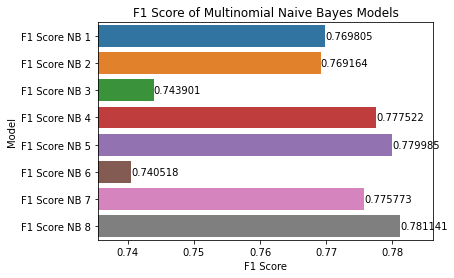

In [34]:
# Plotting F1 scores
fig, ax = plt.subplots()
sns.barplot(x = "F1 Score", y= "Model", data= NB_results).set(title = 'F1 Score of Multinomial Naive Bayes Models')
ax.set_xlim(min(NB_results['F1 Score']) - 0.005, max(NB_results['F1 Score']) + 0.005)
ax.bar_label(ax.containers[0]);

As seen from the results of the word and character n-grams, it is observed that **character 4-gram based on lemmatized text** has the F1 score of 0.7811.

Thus, for the subsequent models, it will be based on that column.

# Training the Multinomial NB model on Character 4-gram based on Lemmatized Text

In [17]:
multi_nb = gs_cvec_multinomial_char.fit(X8_train, y8_train)

# Saving Multinomial NB Model

In [20]:
# Saving
pickle.dump(multi_nb, open("../Capstone/multi_nb.pkl", "wb"))

In [12]:
# Loading
multi_nb_model = pickle.load(open("../Capstone/multi_nb.pkl", "rb"))

In [13]:
# Predicting tags on train set
multi_nb_model_pred = multi_nb_model.predict(X8_train)

In [14]:
# Calculating f1-score on train set
multi_nb_train_f1 = f1_score(y8_train,multi_nb_model_pred, average = 'weighted')

In [15]:
multi_nb_train_f1

0.8073134404462712

There is a small difference betweeen the f1 score on the train set (0.807) and the validation set (0.781), it can be observed that the Multinomial Naive Bayes model do not have significant overfitting on the train set and can generalize to the validation set.

# Exporting Dataset

This dataset will only contain the Annotation (mapped to integers), and the column of character 4-gram based on lemmatized text ('Text_lemm_char_4_gram').

In [35]:
twitter_final4 = twitter_final3[['Annotation','Text_lemm_char_4_gram']]

In [36]:
twitter_final4.to_csv('../Capstone/data/twitter_char_4_gram_lemm_text.csv', index = False)